### **Video Recommendation System**

Aim Is to Build a **Video Recommendation System** similar to youtube, where we used **movie lens dataset** ([link](https://drive.google.com/drive/folders/1SPKPDmHy0CuggaO7eC3UM4BJUhJ8-QQ7?usp=sharing)) and **PyTorch** as **framework**.

> **Dataset :** It has reviews for 100,000 movies from 1000 users on a total of 1700 movies. It also has metadata and user information attached to it so this is probably the closest we can get with representation of actual youtube data using a public dataset.

> **Reference :** https://data-flair.training/blogs/youtube-video-recommendation-system-ml/

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/My Drive/datasets')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import random
from tqdm import tqdm_notebook
from tqdm.notebook import tqdm
from copy import deepcopy

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_path = 'ml-100k/'

In [5]:
id_val = 1
num_users = 943
num_items = 1682

train_dataframe = pd.read_csv(f'{data_path}u{id_val}.base',sep='\t',header=None)
train_dataframe.columns = ['user_id','item_id','rating','ts']
train_dataframe['user_id'] = train_dataframe['user_id'] -1
train_dataframe['item_id'] = train_dataframe['item_id'] -1

train_dataframe.head()

,user_id,item_id,rating,ts
0,0,0,5,874965758
1,0,1,3,876893171
2,0,2,4,878542960
3,0,3,3,876893119
4,0,4,3,889751712


In [6]:
valid_df = pd.read_csv(f'{data_path}u{id_val}.test',sep='\t',header=None)
valid_df.columns = ['user_id','item_id','rating','ts']
valid_df['user_id'] = valid_df['user_id'] -1
valid_df['item_id'] = valid_df['item_id'] -1

valid_df.head()

,user_id,item_id,rating,ts
0,0,5,5,887431973
1,0,9,3,875693118
2,0,11,5,878542960
3,0,13,5,874965706
4,0,16,3,875073198


In [7]:
train_dataframe.shape, valid_df.shape

((80000, 4), (20000, 4))

> The total number of users in our training dataset and validation dataset using unique and getting the length afterwards.

In [8]:
train_usrs = train_dataframe.user_id.unique()
vald_usrs = valid_df.user_id.unique()
len(train_usrs),len(vald_usrs)

(943, 459)

> The total number of items in our training dataset and validation dataset using unique and getting the length afterwards.

In [9]:
train_itms = train_dataframe.item_id.unique()
vald_itms = valid_df.item_id.unique()
len(train_itms),len(vald_itms)

(1650, 1410)



> Create a dataloader class in pytorch to create batches of the training and validation sets.


> **It will return tuples of (user, item, rating)**.





In [10]:
class CollabDataset(Dataset):
    def __init__(self, df, user_col=0, item_col=1, rating_col=2):
        self.df = df
        self.user_tensor = torch.tensor(self.df.iloc[:,user_col], dtype=torch.long, device = device)
        self.item_tensor = torch.tensor(self.df.iloc[:,item_col], dtype=torch.long, device = device)
        self.target_tensor = torch.tensor(self.df.iloc[:,rating_col], dtype=torch.float32, device = device)

    def __getitem__(self, index):
        return(self.user_tensor[index], self.item_tensor[index], self.target_tensor[index])

    def __len__(self):
        return(self.user_tensor.shape[0])



> We set the batch size to 2000 and use dataloader on train and validation dataset.



In [11]:
batch_size = 2000
train_dataset = CollabDataset(train_dataframe)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valid_dataset = CollabDataset(valid_df)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


The model contains two kinds of layers
> First embedding layer to map user and item indices to embedding vectors.

> Then fully connected layers to input those embeddings and output ratings.


In [12]:
class ConcatNet(nn.Module):
    def __init__(self, config):
        super(ConcatNet, self).__init__()
        #hyperparameters
        self.config = config
        self.num_users = config['num_users']
        self.num_items = config['num_items']
        self.emb_size = config['emb_size']
        self.emb_droupout = config['emb_droupout']
        self.fc_layer_sizes = config['fc_layer_sizes']
        self.dropout = config['dropout']
        self.out_range = config['out_range']

        #embeddings
        self.emb_user = nn.Sequential(
            nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.emb_size),
            nn.Dropout(p=self.emb_droupout))
        self.emb_item = nn.Sequential(
            nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.emb_size),
            nn.Dropout(p=self.emb_droupout))

        #fully-connected layers
        fc_layers_list = []
        for ni,nf,p in zip(self.fc_layer_sizes[:-1], self.fc_layer_sizes[1:], self.dropout):
            fc_layers_list.append(nn.Linear(ni, nf))
            fc_layers_list.append(nn.ReLU(inplace=True))
            fc_layers_list.append(nn.BatchNorm1d(nf))
            fc_layers_list.append(nn.Dropout(p=p))
        self.fc_layers = nn.Sequential(*fc_layers_list)

        #output head
        self.head = torch.nn.Linear(in_features=self.fc_layer_sizes[-1], out_features=1)

    def forward(self, user_idx, item_idx):
        user_emb = self.emb_user(user_idx)
        item_emb = self.emb_item(item_idx)
        x = torch.cat([user_emb, item_emb], dim=1)
        x = self.fc_layers(x)
        x = torch.sigmoid(self.head(x))
        x = x * (self.out_range[1] - self.out_range[0]) + self.out_range[0]
        return(x)

Here we define the model completely with all its layers.
> We pass the parameters in the form of config to the model class, three fully connected layers with 100, 256, 512 nodes respectively.


In [13]:
config = {
    'num_users':943,
    'num_items':1682,
    'emb_size':50,
    'emb_droupout': 0.05,
    'fc_layer_sizes': [100, 512, 256],
    'dropout': [0.7,0.35],
    'out_range': [0.8,5.2]}

In [14]:
# model = ConcatNet(config)
# model

Here we declare some hyperparameters for the model.
> The batch size is set to 2000, learning rate, weight decay and others are set.

In [15]:
batch_size = 2000
learning_rate = 1e-2
weight_decay = 5e-1
num_epoch = 100
reduce_learning_rate = 1
early_stoping = 5

Empty lists are created to store losses. We then prepare data loaders for the train and test set.


In [16]:
learning_rates = []
train_losses=[]
valid_losses = []
best_loss = np.inf
best_weights = None

In [17]:
train_dataset = CollabDataset(train_dataframe)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valid_dataset = CollabDataset(valid_df)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

> Use mse or mean squared error as the criterion, and adam optimizer for fast convergence.

In [18]:
model = ConcatNet(config)
criterion = nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9,0.999), weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min',factor=0.5, threshold=1e-3,
                                                       patience=reduce_learning_rate, min_lr=learning_rate/10)

Now the actual training begins,
> Use tqdm to create a progress bar.

> Load the data, pass it through the model, calculate the loss and then backward propagate the loss, change the learning rate and append the losses to the empty lists we created earlier.

Same for the validation,
> Get the validation data, pass it through the model to calculate the loss but this time we do not backward propagate the losses.

> And all of the validation is done in model.eval() putting the model in the evaluation phase.

Calculate the validation loss and based on that save the best model,
> The one with the lowest validation loss.

> Also implement early stopping and stop the model training without running all the epochs if we see the loss becomes stable or is not decreasing. This saves from overfitting and also wasting time.

In [19]:
for e in tqdm(range(num_epoch)):

    model.train()
    train_loss = 0
    for u,i,r in train_dataloader:
        r_pred = model(u,i)
        r = r[:,None]

        loss = criterion(r_pred,r)

        optim.zero_grad()
        loss.backward()
        optim.step()
        train_loss+= loss.detach().item()
    current_learning_rate = scheduler.optimizer.param_groups[0]['lr']
    learning_rates.append(current_learning_rate)
    train_loss /= len(train_dataset)
    train_losses.append(train_loss)

    model.eval()
    valid_loss = 0
    for u,i,r in valid_dataloader:
        r_pred = model(u,i)
        r = r[:,None]
        loss = criterion(r_pred,r)
        valid_loss+=loss.detach().item()
    valid_loss/=len(valid_dataset)
    #record
    valid_losses.append(valid_loss)
    print(f'Epoch {e} Train loss: {train_loss}; Valid loss: {valid_loss}; Learning rate: {current_learning_rate}')

    if valid_loss < best_loss:
        best_loss = valid_loss
        best_weights = deepcopy(model.state_dict())
        no_improvements = 0
    else:
        no_improvements += 1

    if no_improvements >= early_stoping:
        print(f'early stopping after epoch {e}')
        break

    scheduler.step(valid_loss)

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0 Train loss: 1.3778270874023437; Valid loss: 1.1651363037109375; Learning rate: 0.01
Epoch 1 Train loss: 1.0906710510253905; Valid loss: 1.0459931274414063; Learning rate: 0.01
Epoch 2 Train loss: 0.9773839508056641; Valid loss: 0.9717891296386719; Learning rate: 0.01
Epoch 3 Train loss: 0.9265226669311524; Valid loss: 0.9542499938964843; Learning rate: 0.01
Epoch 4 Train loss: 0.9031087127685546; Valid loss: 0.9340476501464844; Learning rate: 0.01
Epoch 5 Train loss: 0.8848964126586915; Valid loss: 0.92836552734375; Learning rate: 0.01
Epoch 6 Train loss: 0.8728381698608398; Valid loss: 0.9098318725585938; Learning rate: 0.01
Epoch 7 Train loss: 0.8676009887695313; Valid loss: 0.9045198608398437; Learning rate: 0.01
Epoch 8 Train loss: 0.8549504959106445; Valid loss: 0.8879039367675782; Learning rate: 0.01
Epoch 9 Train loss: 0.8400340606689453; Valid loss: 0.888576904296875; Learning rate: 0.01
Epoch 10 Train loss: 0.8278031845092774; Valid loss: 0.882504638671875; Learning ra

> We can see here that we wanted the model to train for 100 epochs but the loss became stable after 21 epochs. So we stopped the training at that point and saved the model.



> Now we plot the model training curve to see how the loss decreased and how the validation and training loss differs.

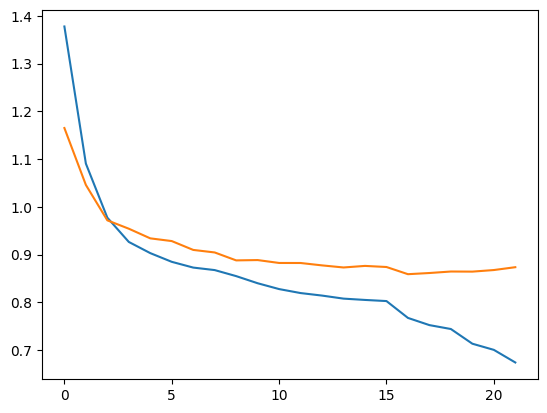

In [20]:
plt.plot(train_losses)
plt.plot(valid_losses)

Successfully created video recommendation system using a deep learning model.

This is because of its efficiency and ability to handle such a large amount of data, in a time limited scenario.

Referred the architecture and reasonings of the paper Deep Neural Network for youtube video recommendation system. And This project to know how it works and how to build one.